#### Введение
______
**Название проекта**  

Статистический анализ данных сервиса аренды самокатов.
_____

**Цель исследования**  

Провести анализ данных о пользователях из нескольких городов, их тарифов и поездках и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.
_______
**Задачи исследования**

- Провести необходимую предобработку датасетов
- Провести исследовательский анализ данных с учетом их типа
- Объединенить данные о пользователях, поездках и подписках в один датафрейм
- Рассчитать выручку, которую принёс каждый пользователь в зависимости от тарифа
- Проверить ряд гипотез и провести работу с распределениями с целью увеличения количества пользователей с подпиской

_____
**Исходные данные**  

Имеются данные, представленные в виде трех датасетов, которые содержат следующую информацию:

`users_go.csv` —  данные о пользователях:
- `user_id` - уникальный идентификатор пользователя
- `name` - имя пользователя
- `age` - возраст
- `city` - город
- `subscription_type` - тип подписки (free, ultra)

`subscriptions_go.csv` —  данные о подписках пользователей:
- `subscription_type` - тип подписки
- `minute_price` - стоимость одной минуты поездки по данной подписке
- `start_ride_price` - стоимость начала поездки
- `subscription_fee` - стоимость ежемесячного платежа

`rides_go.csv` —  данные о поездках пользователей:
- `user_id` - уникальный идентификатор пользователя
- `distance` - расстояние, которое пользователь проехал в текущей сессии (в метрах)
- `duration` - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- `date` - дата совершения поездки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
import scipy.stats as st
from scipy.stats import norm
from scipy.stats import binom

plt.style.use('default')
plt.rcParams['figure.figsize'] = (6, 4)
pd.set_option('display.max_columns', None)

#### Загрузка данных

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

##### Общая информация о датасете "Пользователи"

In [3]:
users.head(3)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Зафиксируем начальное количество данных в переменную `shape_users_start`

In [5]:
shape_users_start = users.shape
shape_users_start

(1565, 5)

In [6]:
users.describe()

,user_id,age
count,1565.000000,1565.000000
mean,762.633866,24.922045
std,443.260155,4.553496
min,1.000000,12.000000
25%,378.000000,22.000000
50%,762.000000,25.000000
75%,1146.000000,28.000000
max,1534.000000,43.000000


##### Общая информация о датасете "Поездки"

In [7]:
rides.head(3)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20


In [8]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Зафиксируем начальное количество данных в переменную `shape_rides_start`

In [9]:
shape_rides_start = rides.shape
shape_rides_start

(18068, 4)

In [10]:
rides.describe()

,user_id,distance,duration
count,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,17.805011
std,434.734317,1116.831209,6.091051
min,1.000000,0.855683,0.500000
25%,487.000000,2543.226360,13.597563
50%,889.000000,3133.609994,17.678395
75%,1213.250000,3776.222735,21.724800
max,1534.000000,7211.007745,40.823963


##### Общая информация о датасете "Подписки"

In [11]:
subscriptions.head(3)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [12]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Загружены и получена общая информация по трем датасетам: "Пользователи", "Поездки", "Подписки", пропуски в данных отсутствуют, зафиксирован первоначальный объем датасетов

#### Предобработка данных

##### Изменение типов данных

Приведем к формату дата значения столбца "дата совершения поездки"

In [13]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d' )

In [14]:
print(rides['date'].dtypes)

datetime64[ns]


Создадим новый столбец с номером месяца на основе столбца "дата совершения поездки"

In [15]:
rides['month'] = rides['date'].dt.month

In [16]:
rides.head(3)

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4


В целях экономии памяти и в отсутствии необходимости в расчетах значительной точности переведем в 32-битный разряд данные из датасетов

In [17]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [18]:
users = users.astype({'user_id': 'int32', 'age': 'int32'})
rides = rides.astype({'user_id': 'int32', 'month': 'int32',\
                      'distance': 'float32', 'duration': 'float32'})
subscriptions = subscriptions.astype({'minute_price': 'int32', 'start_ride_price': 'int32',\
                                      'subscription_fee': 'int32'})

##### Обработка дубликатов

Проверим на наличие явных строк-дубликатов в данных, удалим в случае наличия¶

In [19]:
users.duplicated().sum()

31

In [20]:
users = users.drop_duplicates()

In [21]:
rides.duplicated().sum()

0

In [22]:
sorted(users['city'].unique())

['Екатеринбург',
 'Краснодар',
 'Москва',
 'Омск',
 'Пятигорск',
 'Ростов-на-Дону',
 'Сочи',
 'Тюмень']

In [23]:
users = users.reset_index(drop=True)

По результатам предобработки данные были преобразованы в необходимые типы, явные дубликаты удалены, пропуски, а также неявные дубликаты - отсутствуют

#### Исследовательский анализ данных

Опишем и визуализируем общую информацию о пользователях и поездках

##### Частота встречаемости городов

In [24]:
users['city'].describe()

count          1534
unique            8
top       Пятигорск
freq            219
Name: city, dtype: object

In [25]:
print('Наиболее часто встречающийся город:', users['city'].mode()[0])

Наиболее часто встречающийся город: Пятигорск


В связи с тем, что рассматриваемые данные категориальные, используем для описания столбчатую диаграмму:

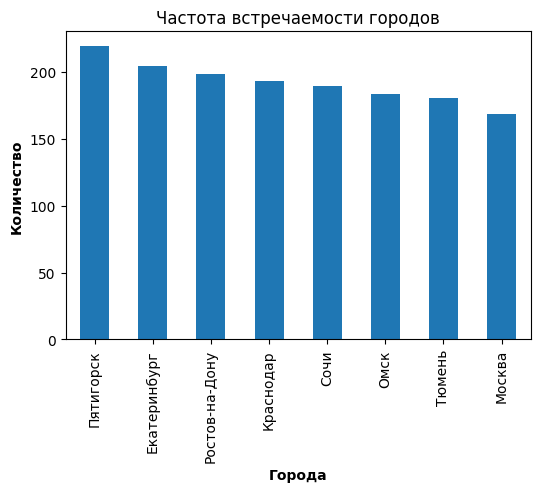

In [26]:
users['city'].value_counts().plot.bar()
plt.title("Частота встречаемости городов")
plt.xlabel("Города", fontweight="bold")
plt.ylabel("Количество", fontweight="bold")
plt.show()

In [27]:
users['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

Всего в столбце 8 городов, наиболее часто встречающийся город - Пятигорск, разброс по частоте присутствия городов незначительный

##### Соотношение пользователей с подпиской и без подписки

В связи с тем, что рассматриваемые данные категориальные, используем для описания круговую диаграмму:

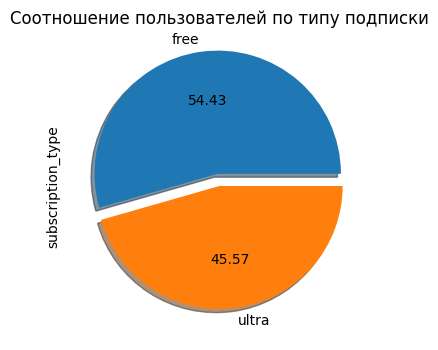

In [28]:
explode = (0.1, 0)
users['subscription_type'].value_counts().plot.pie(shadow=True, explode=explode, autopct='%.2f')
plt.title("Соотношение пользователей по типу подписки")
plt.show()

In [29]:
users['subscription_type'].value_counts()

free     835
ultra    699
Name: subscription_type, dtype: int64

In [30]:
users_free = users.loc[users['subscription_type'] == 'free', 'user_id'].count()
users_ultra = users.loc[users['subscription_type'] == 'ultra', 'user_id'].count()
print(f'Количество пользователей с подпиской "free" составляет: {users_free} или {users_free/len(users):.1%}')
print(f'Количество пользователей с подпиской "ultra" составляет: {users_ultra} или {users_ultra/len(users):.1%}')

Количество пользователей с подпиской "free" составляет: 835 или 54.4%
Количество пользователей с подпиской "ultra" составляет: 699 или 45.6%


##### Возраст пользователей

В связи с тем, что рассматриваемые данные дискретные, используем для описания столбчатую диаграмму:

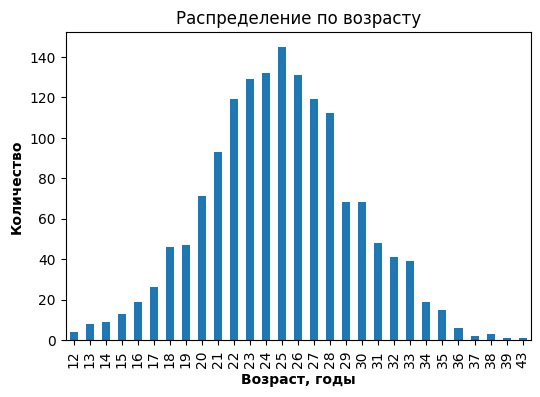

In [31]:
users['age'].value_counts().sort_index(ascending=True) .plot.bar()
plt.title("Распределение по возрасту")
plt.xlabel("Возраст, годы", fontweight="bold")
plt.ylabel("Количество", fontweight="bold")
plt.show()

In [32]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Возраст пользователей колеблется от 12 до 43 лет, основная их масса - 75% лежит в пределах до 28 лет включительно. Средний возраст почти совпадает с медианным и составляет 25 лет, что означает, что отстутствуют серьезные выбросы, оказывающие значительное влияние на среднее значение.

##### Расстояние, которое пользователь преодолел за одну поездку

В связи с тем, что рассматриваемые данные непрерывные, используем для описания гистограмму и диаграмму размаха:

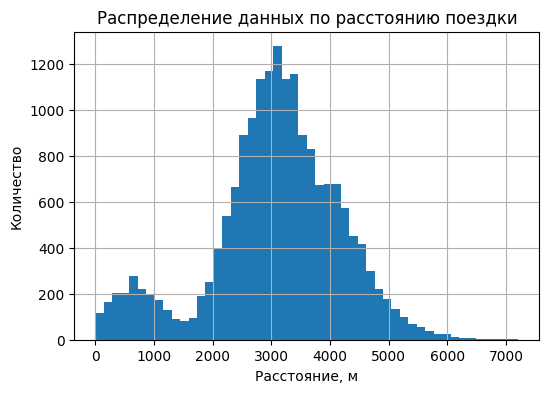

In [33]:
rides['distance'].hist(bins=50)
plt.title("Распределение данных по расстоянию поездки")
plt.xlabel("Расстояние, м")
plt.ylabel("Количество")
plt.show()

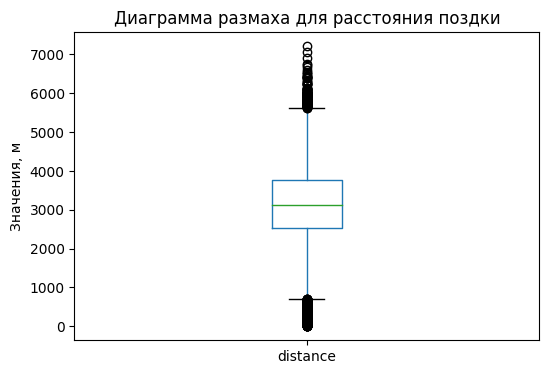

In [34]:
rides['distance'].plot.box()
plt.title("Диаграмма размаха для расстояния поздки")
plt.ylabel("Значения, м")
plt.show()

In [35]:
rides['distance'].describe()

count    18068.000000
mean      3070.660156
std       1116.831177
min          0.855683
25%       2543.226318
50%       3133.609985
75%       3776.222717
max       7211.007812
Name: distance, dtype: float64

Основной объем поездок - 75% приходится на поездки в пределах 4 км. Максимальная дальность поездки - 7.2 км. Среднее расстояние поездки почти совпадает с медианным и составляет приблизительно 3 км, что означает, что отстутствуют серьезные выбросы, оказывающие значительное влияние на среднее значение поездки.

##### Продолжительность поездок

В связи с тем, что рассматриваемые данные непрерывные, используем для описания гистограмму и диаграмму размаха:

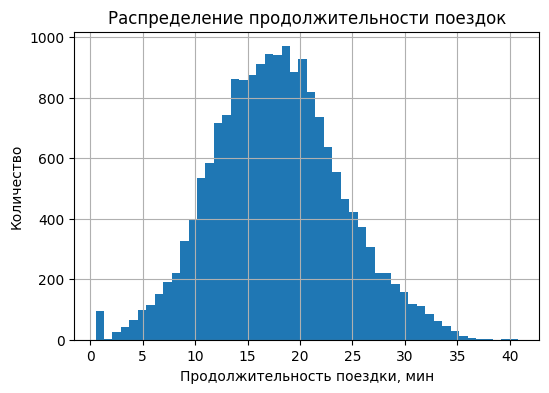

In [36]:
rides['duration'].hist(bins=50)
plt.title("Распределение продолжительности поездок")
plt.xlabel("Продолжительность поездки, мин")
plt.ylabel("Количество")
plt.show()

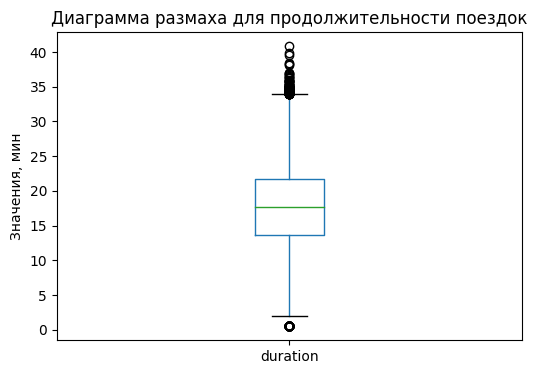

In [37]:
rides['duration'].plot.box()
plt.title("Диаграмма размаха для продолжительности поездок")
plt.ylabel("Значения, мин")
plt.show()

Обратим внимание на минимальные значения длительности поездки

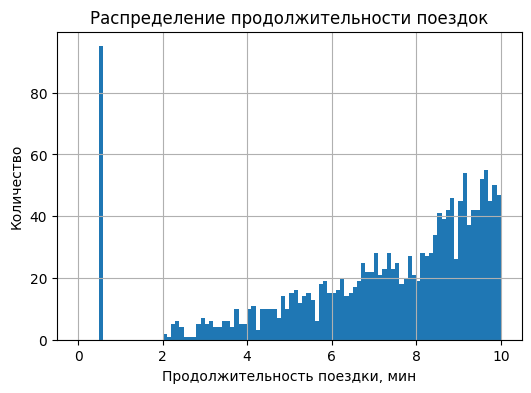

In [38]:
rides['duration'].hist(bins=100, range=(0,10))
plt.title("Распределение продолжительности поездок")
plt.xlabel("Продолжительность поездки, мин")
plt.ylabel("Количество")
plt.show()

В связи с тем, что расстояние поездки и ее длительность имеют известную зависимость, посмотрим наличие аномалий на диаграммах рассеивания, построенных на основе пар этих двух параметров, а также для соответствующих им скоростей.

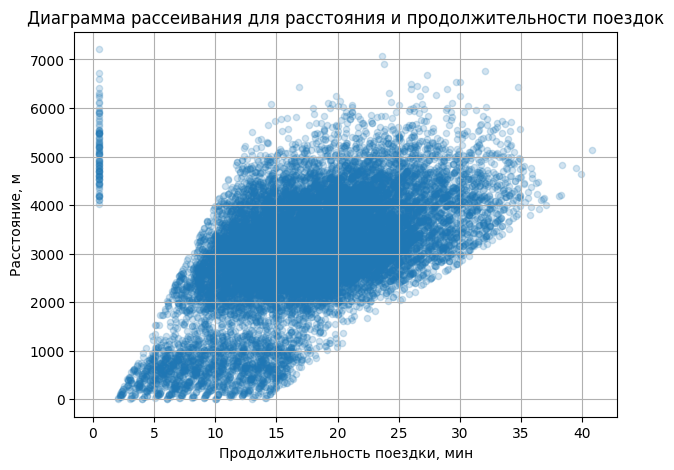

In [39]:
rides.plot(x='duration', y='distance', kind='scatter', alpha=0.2, figsize=(7, 5), \
           sharex=False, grid=True)
plt.title("Диаграмма рассеивания для расстояния и продолжительности поездок")
plt.xlabel("Продолжительность поездки, мин")
plt.ylabel("Расстояние, м")
plt.show()

In [40]:
velocity = rides['distance'] / rides['duration']
velocity = velocity.reset_index()
velocity.columns = ['measuring', 'velocity']

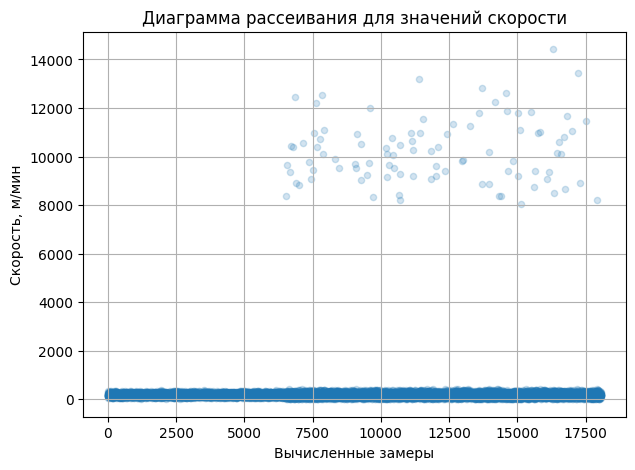

In [41]:
velocity.plot(x='measuring', y='velocity', kind='scatter', alpha=0.2, figsize=(7, 5), sharex=False, grid=True)
plt.title("Диаграмма рассеивания для значений скорости")
plt.xlabel("Вычисленные замеры")
plt.ylabel("Скорость, м/мин")
plt.show()

Принимая во внимание тот факт, что за 0.5 мин невозможно проехать расстояния от 4 до 7 км, что соответствует скоростям на графике от 8000 м/мин и выше, примем записи со значениями длительности поездки менее 2 мин за аномальные и исключим их из дальнейшего анализа

In [42]:
len(rides.query('duration < 2'))

95

In [43]:
rides = rides.query('duration >= 2')

In [44]:
rides['duration'].describe()

count    17973.000000
mean        17.896481
std          5.975424
min          2.035632
25%         13.670439
50%         17.714123
75%         21.747017
max         40.823963
Name: duration, dtype: float64

Проверим скорости на диаграмме рассеивания после удаления аномалий

In [45]:
velocity = rides['distance'] / rides['duration']
velocity = velocity.reset_index()
velocity.columns = ['measuring', 'velocity']

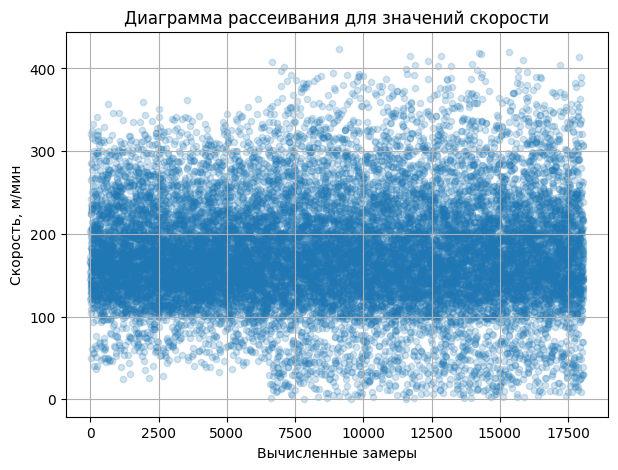

In [46]:
velocity.plot(x='measuring', y='velocity', kind='scatter', alpha=0.2,\
              figsize=(7, 5), sharex=False, grid=True)
plt.title("Диаграмма рассеивания для значений скорости")
plt.xlabel("Вычисленные замеры")
plt.ylabel("Скорость, м/мин")
plt.show()

Основной объем поездок - 75% приходится на поездки до 22 мин. Максимальная продолжительность поездки - 41 мин. Среднее время поездки почти совпадает с медианным и составляет приблизительно 18 мин, что означает, что в "очищенном" датасете отстутствуют серьезные выбросы, оказывающие значительное влияние на среднее значение времени поездки.

In [47]:
shape_rides = rides.shape
print(f'Доля текущего объема данных относительно первоначального составляет: {shape_rides[0]/shape_rides_start[0]:.1%}')

Доля текущего объема данных относительно первоначального составляет: 99.5%


**Вывод:** исследовательский анализ данных показал, что рассматриваемые данные достаточно однородны, исключено незначительное количество аномалий, по итогам анализа данные сохранены в объеме 99.5%.

#### Объединение данных

##### Объединение данных о пользователях, поездках и подписках в один датафрейм `total`

Округлим продолжительность каждой поездки для последующих рассчетов стоимости до следующего целого числа

In [48]:
rides['duration'] = np.ceil(rides['duration']) 

/tmp/ipykernel_106/3852200884.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rides['duration'] = np.ceil(rides['duration'])


In [49]:
total = users.merge(rides, on='user_id', how='outer')
total = total.merge(subscriptions, on='subscription_type', how='outer')
total.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.918945,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592041,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159790,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783203,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687256,27.0,2021-08-28,8,6,0,199


Проверим объединенную таблицу на отсутствие пропусков и соответствие ожидаемому размеру

In [50]:
total.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

In [51]:
len(rides)

17973

In [52]:
len(total)

17973

##### Создание из `total`  датафрейма c данными о пользователях без подписки `total_free`

In [53]:
total_free = total.query('subscription_type == "free"')
total_free = total_free.reset_index(drop=True)

##### Создание из `total`  датафрейма c данными о пользователях с подпиской `total_ultra`

In [54]:
total_ultra = total.query('subscription_type == "ultra"')
total_ultra = total_ultra.reset_index(drop=True)

##### Визуализация информации о расстоянии и времени поездок для пользователей с подпиской и без

Гистограмма распределения расстояния в зависимости от категории подписки

Медиана расстояний поездок пользователей без подписки: 3102 м
Медиана расстояний поездок пользователей c подпиской: 3149 м


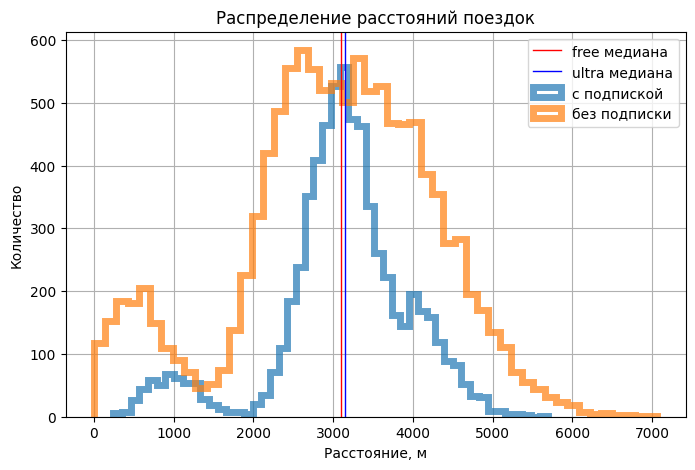

In [55]:
ax = total_ultra.plot(
    kind='hist',
    y='distance',
    histtype='step',
    bins=50,
    linewidth=5,
    alpha=0.7,
    label='с подпиской',
)
total_free.plot(
    kind='hist',
    y='distance',
    histtype='step',
    bins=50,
    linewidth=5,
    alpha=0.7,
    label='без подписки',
    ax=ax,
    grid=True,
    legend=True,
    figsize=(8, 5),
    title='Распределение расстояний поездок'
)

# Добавим медианы на график
free_distance_median = total_free['distance'].median()
ultra_distance_median = total_ultra['distance'].median()
print('Медиана расстояний поездок пользователей без подписки:',\
      round(free_distance_median),'м')
print('Медиана расстояний поездок пользователей c подпиской:',\
      round(ultra_distance_median),'м')

plt.axvline(x=free_distance_median, ymin=0, ymax = 1, linewidth=1, color='r', label='free медиана')
plt.axvline(x=ultra_distance_median, ymin=0, ymax = 1, linewidth=1, color='b', label='ultra медиана')
plt.legend()
plt.xlabel("Расстояние, м")
plt.ylabel("Количество")
plt.show()

Гистограмма распределения времени поездки в зависимости от категории подписки

Медиана продолжительности поездок поездок пользователей без подписки: 18 мин
Медиана продолжительности поездок пользователей c подпиской: 19 мин


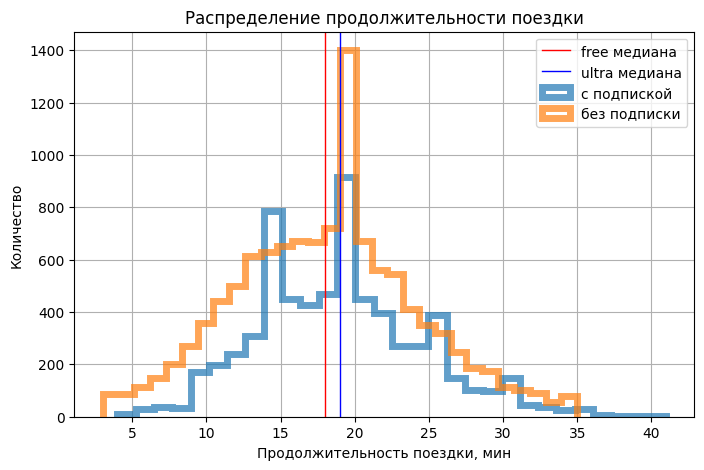

In [56]:
ax = total_ultra.plot(
    kind='hist',
    y='duration',
    histtype='step',
    bins=30,
    linewidth=5,
    alpha=0.7,
    label='с подпиской',
)
total_free.plot(
    kind='hist',
    y='duration',
    histtype='step',
    bins=30,
    linewidth=5,
    alpha=0.7,
    label='без подписки',
    ax=ax,
    grid=True,
    legend=True,
    figsize=(8, 5),
    title='Распределение продолжительности поездки'
)
# Добавим медианы на график
free_duration_median = total_free['duration'].median()
ultra_duration_median = total_ultra['duration'].median()
print('Медиана продолжительности поездок поездок пользователей без подписки:',\
      round(free_duration_median),'мин')
print('Медиана продолжительности поездок пользователей c подпиской:',\
      round(ultra_duration_median),'мин')

plt.axvline(x=free_duration_median, ymin=0, ymax = 1, linewidth=1, color='r', label='free медиана')
plt.axvline(x=ultra_duration_median, ymin=0, ymax = 1, linewidth=1, color='b', label='ultra медиана')
plt.legend()
plt.xlabel("Продолжительность поездки, мин")
plt.ylabel("Количество")
plt.show()

Дополним графики сводной таблицей, сгруппированной по типу подписки

In [57]:

total_svod = total.groupby('subscription_type').agg({'distance': ['count', 'sum'], 'duration': 'sum'})
total_svod.columns = ['count', 'sum_distance', 'sum_duration']
round(total_svod)


,count,sum_distance,sum_duration
subscription_type,,,
free,11473,34744536.0,206868.0
ultra,6500,20250396.0,123745.0


**Вывод:** из графиков видно, что основной объем поездок для пользователей без подписки приходится на диапазон 2-4,5 км, тогда как для пользователей с подпиской он более выражен и находится в диапазоне 2,5-3,5 км. Можно предположить, что люди более точно представляющие для какого раастояния им постоянно требуется самокат и приобретают подписку. В целом количество данных о поездках пользователей с подпиской составляет примерно треть от общего количества записей.

#### Подсчёт выручки

##### Создание датафрейма с агрегированными данными о поездках: суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц

In [58]:
total_user = total.groupby(['user_id', 'name', 'minute_price', 'start_ride_price',\
                             'subscription_fee', 'month'])\
                            .agg({'distance': ['count', 'sum'], 'duration': 'sum'})\
                            .reset_index()

total_user.columns = ['user_id', 'name', 'minute_price', 'start_ride_price',\
                      'subscription_fee', 'month', 'count', 'sum_distance', 'sum_duration']
total_user.head()

,user_id,name,minute_price,start_ride_price,subscription_fee,month,count,sum_distance,sum_duration
0,1,Кира,6,0,199,1,2,7027.510742,42.0
1,1,Кира,6,0,199,4,1,754.159790,7.0
2,1,Кира,6,0,199,8,2,6723.470703,46.0
3,1,Кира,6,0,199,10,2,5809.911133,32.0
4,1,Кира,6,0,199,11,3,7003.499512,56.0


##### Добавление столбца с помесячной выручкой, которую принёс каждый пользователь. 

In [59]:
# Создадим функцию для расчета помесячной выручки
def profit_users(row):
    try:
        profit_users = row['count'] * row['start_ride_price'] \
                        + row['sum_duration'] * row['minute_price'] \
                        + row['subscription_fee']
        return profit_users
    except:
        return 'ошибка при определении стоимости'

In [60]:
total_user['profit_users'] = total_user.apply(profit_users, axis=1)
total_user.head()

,user_id,name,minute_price,start_ride_price,subscription_fee,month,count,sum_distance,sum_duration,profit_users
0,1,Кира,6,0,199,1,2,7027.510742,42.0,451.0
1,1,Кира,6,0,199,4,1,754.159790,7.0,241.0
2,1,Кира,6,0,199,8,2,6723.470703,46.0,475.0
3,1,Кира,6,0,199,10,2,5809.911133,32.0,391.0
4,1,Кира,6,0,199,11,3,7003.499512,56.0,535.0


In [61]:
total_user['profit_users'].sum()

3873131.0

#### Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.

##### Проверка гипотезы, что пользователи с подпиской тратят больше времени на поездки

Сформулируем одностороннюю гипотезу:
- нулевая гипотеза: между средними значениями времени поздки двух совокупностей пользователей с подпиской и без нет разницы, они равны
- альтернативная гипотеза: пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки. 

В связи с тем, что выборки независимые, используем **двухвыборочный t-тест для независимых выборок**

Выборки разного размера и при этом достаточно велики, чтобы и по отдельности точно оценить дисперсию каждой генеральной совокупности. Их объединение не сильно увеличит точность оценки дисперсии, поэтому укажем дополнительный параметр неравной дисперсии.

In [62]:
# задаём уровень значимости
alpha = .05

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(total_ultra['duration'], total_free['duration'], equal_var=False, alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')
    
# Дополнительно отобразим медианы этих выборок
print()
print('Медиана продолжительности поездок пользователей c подпиской:',\
      round(total_ultra['duration'].median()),'мин')
print('Медиана продолжительности поездок пользователей c подпиской:',\
      round(total_free['duration'].median()),'мин')

p-value: 3.086107246436936e-29
Отвергаем нулевую гипотезу

Медиана продолжительности поездок пользователей c подпиской: 19 мин
Медиана продолжительности поездок пользователей c подпиской: 18 мин


**Вывод:** есть основания говорить, что пользователи с подпиской тратят значимо больше времени на поездки.

##### Проверка гипотезы, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, превышает 3130 метров

Сформулируем одностороннюю гипотезу:
- нулевая гипотеза: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 м.
- альтернативная гипотеза: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, больше 3130 м.

Используем **одновыборочный t-тест**

In [63]:
interested_value = 3_130 

alpha = .05 # уровень статистической значимости

results = st.ttest_1samp(total_ultra['distance'], interested_value, alternative='greater')

print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: среднее расстояние значимо больше 3 130 метров')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    
print('Среднее расстояние одной поездки пользователя с подпиской составляет:',\
     round(total_ultra['distance'].mean()),'м')

p-value: 0.9195344662352914
Не получилось отвергнуть нулевую гипотезу
Среднее расстояние одной поездки пользователя с подпиской составляет: 3115 м


**Вывод:** гипотеза, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, значимо больше 3 130 метров не подтвердилась

##### Проверка гипотезы, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

Сформулируем одностороннюю гипотезу:
- нулевая гипотеза: между средними значениями помесячной выручки двух совокупностей пользователей с подпиской и без нет разницы, они равны
- альтернативная гипотеза: помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

В связи с тем, что выборки независимые, используем **двухвыборочный t-тест для независимых выборок**

Выборки разного размера и при этом достаточно велики, чтобы и по отдельности точно оценить дисперсию каждой генеральной совокупности. Их объединение не сильно увеличит точность оценки дисперсии, поэтому укажем дополнительный параметр неравной дисперсии.

In [64]:
# задаём уровень значимости
alpha = .05

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(total_user.loc[total_user['subscription_fee'] > 0, 'profit_users'], \
                       total_user.loc[total_user['subscription_fee'] == 0, 'profit_users'], \
                       alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 2.0314113674863288e-30
Отвергаем нулевую гипотезу


**Вывод:** есть основания говорить, что помесячная выручка от пользователей с подпиской по месяцам значимо выше, чем выручка от пользователей без подписки

##### Вид теста для проверки гипотезы об изменении количества обращений в техподдержку 

Ситуация: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

**Ответ:** В связи с тем, рассматривается одна и таже совокупность и имеются измерения одной и той же переменной (количество обращений) до и после некоторого изменения (обновление серверов), то такие выборки с рассматриваемой переменной являются зависимыми и для проверки гипотезы необходимо использовать **двухвыборочный t-тест для зависимых выборок**.

#### Распределения

##### Расчет минимального количества промокодов 

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10% пользователей. 

Необходимо выяснить, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5%.

Данную ситуацию описывает биномиальное распределение. Аппроксимируем биномиальное распределение нормальным и проведем необходимые расчеты

In [65]:
plan = 100 # запланированное кол-во клиентов, которое должно продлить акционную подписку

# задаём параметры биномиального распределения
n = 1161
p = .1

# считаем вероятность хвоста слева 
result = st.binom(n, p).cdf(plan - 1)

print(round(result, 4))

0.0498


In [66]:
#Код ревьюера

st.binom(2, 0.5).cdf(1)

0.75

**Вывод:** расчет показал, что необходимо разослать минимум 1161 промокод, для чтобы вероятность не выполнить план, по которому как минимум 100 существующих клиентов должны продлить акционную подписку, была примерно 5%.

Построим график биномиального распределения

/opt/conda/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


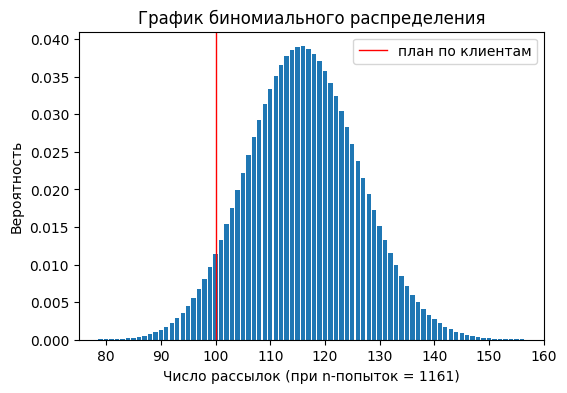

In [67]:
# Визуализируем биномиальное распределение

distr = []

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)
    
plt.bar(range(0, n + 1), distr)

plt.title("График биномиального распределения")
plt.xlabel("Число рассылок (при n-попыток = 1161)")
plt.ylabel("Вероятность")
plt.xlim(75, 160)
plt.axvline(x=plan, ymin=0, ymax = 1, linewidth=1, color='r', label='план по клиентам')
plt.legend()
plt.show()

##### Оценка вероятности открытия уведомления заданным количеством пользователей

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации необходимо построить примерный график распределения и оценить вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Данную ситуацию описывает биномиальное распределение. Аппроксимируем биномиальное распределение нормальным и проведем необходимые расчеты

In [68]:
plan = 399_500 # количество пользователей, которые откроют уведомление

# задаём параметры биномиального распределения
n = 1_000_000
p = .4

# зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение
distr = st.norm(mu, sigma) 

# считаем вероятность хвоста слева 
result = distr.cdf(plan)
print(round(result, 4))

0.1537


**Вывод:** расчет показал, что с вероятностью 15,4% уведомление откроют не более 399,5 тыс. пользователей.

Построим график нормального распределения, которым аппроксимируем биномиальное распределение

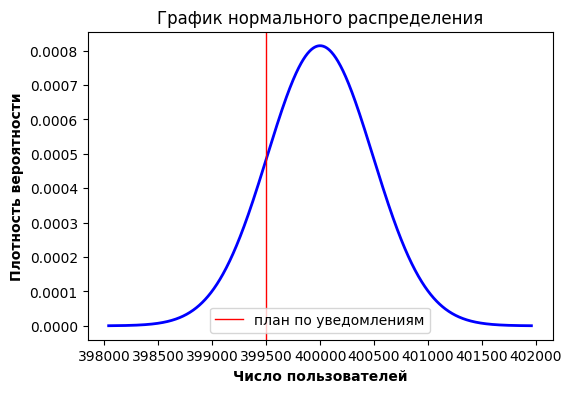

In [70]:
# зададим функцию, которая выдает <num> чисел, равномерно распределенных от <start> до <stop>
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result

# границы промежутка, на котором будем строить график:
left = int(mu - 4 * sigma)
right = int(mu + 4 * sigma)

# график нормального распределения
x = linspace(left, right, 1000)
theplot = plt.subplot()
theplot.plot(x, norm.pdf(x, mu, sigma), 'b-', lw=2)

plt.title("График нормального распределения")
plt.xlabel("Число пользователей", fontweight="bold")
plt.ylabel("Плотность вероятности", fontweight="bold")
plt.axvline(x=plan, ymin=0, ymax = 1, linewidth=1, color='r', label='план по уведомлениям')
plt.legend()

plt.show()

#### Общий вывод:

**В рамках проекта  была проведена:** предобработка данных, объединение датасетов для целей дальнейшего анализа, проведен исследовательский анализ данных с необходимой визуализацией, подсчет помесячной выручки для каждого пользователя, проверка различных гипотез и построение распределений. 

**На этапе предобработки данных:** произведено необходимое изменение типов данных, явные дубликаты удалены, проведена проверка на пропуски, а также неявные дубликаты.

**На этапе исследовательского анализа данных:** более глубоко исследованы  данные, предложенные к анализу, в том числе с использованием графических инструментов. Визуализация данных проводилась в соответствии с их типом (дискретные, непрерывные).

Анализ данных показал, что рассматриваемые данные достаточно однородны, исключено незначительное количество аномалий, по итогам анализа данные сохранены в объеме 99.5%.

**На этапе работы с данными и проведения расчетов:** объединены данных о пользователях, поездках и подписках в один датафрейм, созданы отдельные датафреймы c данными о пользователях с подпиской и без, визуализирована информация отдельно о расстоянии и времени поездок для каждой категории подписки с целью возможности наглядного сравнения.

Сформированы необходимые сводные таблицы и произведен расчет помесячной выручки, которую принёс каждый пользователь. 

**На этапе проверки гипотез:** сформулированы необходимые нулевые и альтернативные гипотезы, проведены требуемые расчеты и сделаны следующие выводы:
- есть основания говорить, что пользователи с подпиской тратят значимо больше времени на поездки
- гипотеза, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, значимо больше 3 130 метров не подтвердилась
- есть основания говорить, что помесячная выручка от пользователей с подпиской по месяцам значимо выше, чем выручка от пользователей без подписки

**На этапе работы с распределениями:** были решены задачи, поставленные перед отделом маркетинга в части расчета минимального количества промокодов и оценки вероятности открытия уведомления заданным количеством пользователей. Проведенные расчеты также были визуализированы графически с помощью построения соответствующих графиков распределения.
